In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [144]:
# This file contains all the main external libs we'll use
import fastai
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch.nn as nn 
import torch 
import numpy 
%matplotlib inline

from torch.autograd import Variable
from torchvision import models
from fastai import conv_learner
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform

In [3]:
PATH = "../data_segments/data_balanced_duplicate_sample/"
sz=256
arch=resnet50

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['models', 'tmp', 'valid', 'train']

In [7]:
files = os.listdir(f'{PATH}valid/Celiac')[:5]
files

['C16-77_02_3330_999_1.jpg',
 'C06-27_02_5994_4662_0.jpg',
 'C06-28_02_13653_666_1.jpg',
 'C06-28_02_13320_1332_1.jpg',
 'C06-32_02_5994_2664_0.jpg']

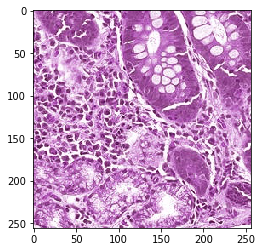

In [8]:
img = plt.imread(f'{PATH}valid/Celiac/{files[4]}')
plt.imshow(img);

In [9]:
arch=resnet50
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [10]:
# Using predefined augmentations transforms_top_down
tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

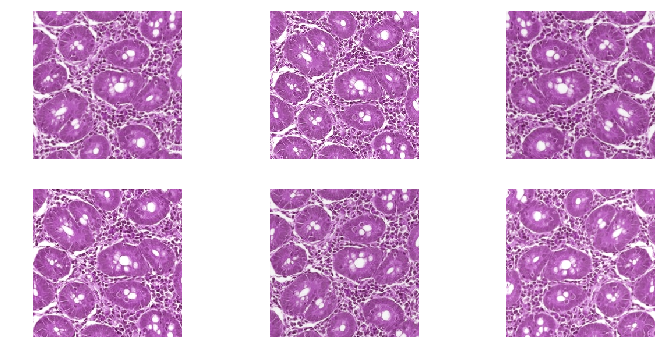

In [11]:
# Visualising the augmentation
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [12]:
# Initializing the data with augmentation and learn method
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.precompute = False

## Unfreezing layers and using Differential learning rates

In [13]:
# Unfreeze all layers for training
learn.unfreeze()

In [23]:
lrf=learn.lr_find()

 70%|███████   | 5139/7308 [46:52<19:08,  1.89it/s, loss=1.05]   

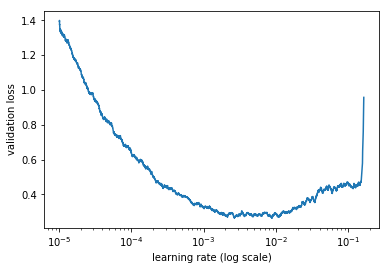

In [24]:
learn.sched.plot()

In [14]:
learn.load('256_all_resnet50_duplicates_staintools')

In [15]:
learn.precompute = False
learn.predict()

array([[ -0.07257,  -8.9605 ,  -2.66109],
       [ -0.00001, -13.56015, -11.8156 ],
       [ -0.00067, -10.93428,  -7.33574],
       ...,
       [ -6.19549, -12.80837,  -0.00204],
       [ -5.62627,  -7.45013,  -0.00419],
       [ -3.05599,  -9.76478,  -0.04828]], dtype=float32)

In [16]:
model = learn.model
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

In [17]:
# Some Helper functions
from PIL import Image
def image_loader(path, expand_dim=False):
    img = Image.open(path)
#     img = img.resize((256, 256))
    img = np.array(img, dtype=np.float32)
    img = np.einsum('ijk->kij', img)
    if expand_dim:
        img = img[None]
    # convert to torch 
    img = torch.from_numpy(img)
    return img

In [18]:
def return_sequential(layer_num, model):
    return nn.Sequential(
            *list(model.children())[:layer_num]
        )

class get_activation_layer(nn.Module):
    def __init__(self, model, total_layers):
        super().__init__()
        self.model = model
        self.total_layers = total_layers
        self.layer_models = []
        for i in range(self.total_layers):
             self.layer_models.append(return_sequential(i, self.model))
    def forward(self, x):
        self.outputs = []
        for i in range(self.total_layers):
            self.outputs.append(self.layer_models[i](x))
        return self.outputs

In [19]:
tmp_model = get_activation_layer(model, 16)

In [39]:
!mkdir ../layers_vis

mkdir: cannot create directory ‘../layers_vis’: File exists


In [61]:
def visulaize_layers(outputs):
    for index, layer in enumerate(outputs):
        features = layer.data
        size_plot = features.shape[1]
        if size_plot % 2 != 0:
            size_plot += 1
        original_size = np.int(np.ceil(np.sqrt(size_plot)))
        f, axarr = plt.subplots(original_size + 1, original_size + 1, figsize=(40,40))
        i, j = 0,0
        counter = 1
        for blocks in features:
            for block in blocks:
                counter += 1
                x = block.cpu().numpy()
                if counter % original_size == 0:
                    i += 1
                    j = 0 

                axarr[i,j].imshow(x)
                j += 1
        counter = 0
        print(f'layer {index} done')
        f.savefig(f'../layers_vis/output{index}.jpg')
        print('image generated')
        if (index == 10):
            break

In [62]:
img_path = f'{PATH}valid/Celiac/C06-27_02_5994_4662_0.jpg'
i = image_loader(f'{PATH}valid/Celiac/C06-27_02_5994_4662_0.jpg', expand_dim=True)
i = i.cuda()

layer_outputs = tmp_model(Variable(i))

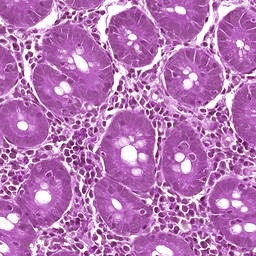

In [63]:
from IPython.display import Image as I
I(img_path)

In [ ]:
visulaize_layers(layer_outputs)

## Plotting Grad CAM

In [ ]:
def get_cat_name(a):
    if a == 0:
        return 'Celiac'
    elif a == 1:
        return 'EE'
    elif a == 

In [65]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [166]:
def plt_heatmap():
    
    m = nn.Sequential(*children(learn.model))
    figure = plt.figure(figsize=(30, 90))

    for i in range(27):
        subplot = figure.add_subplot(9, 3, i+1)
        subplot.axis('Off')
        x,y = next(iter(data.val_dl))
        x,y = x[None,i], y[None,i]
        subplot.set_title(get_cat_name(y))
        vx = Variable(x.cuda(), requires_grad=True)
        dx = data.val_ds.denorm(x)[0]
        sfs = [SaveFeatures(o) for o in [m[-11][2]._modules['conv2']]]
        py = m(vx)
        for o in sfs: o.remove()
        feat = np.maximum(0,to_np(sfs[0].features[0]))
        vx = Variable(x.cuda(), requires_grad=True)
        py = np.exp(to_np(py)[0])
        params = list(m.parameters())
        weight_softmax = np.squeeze(params[-2].data.cpu().numpy())
        f2=np.dot(np.rollaxis(feat,0,3), weight_softmax[0])
        f2-=f2.min()
        f2/=f2.max()
        plt.imshow(dx)
        plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');

/apps/software/standard/core/anaconda3/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


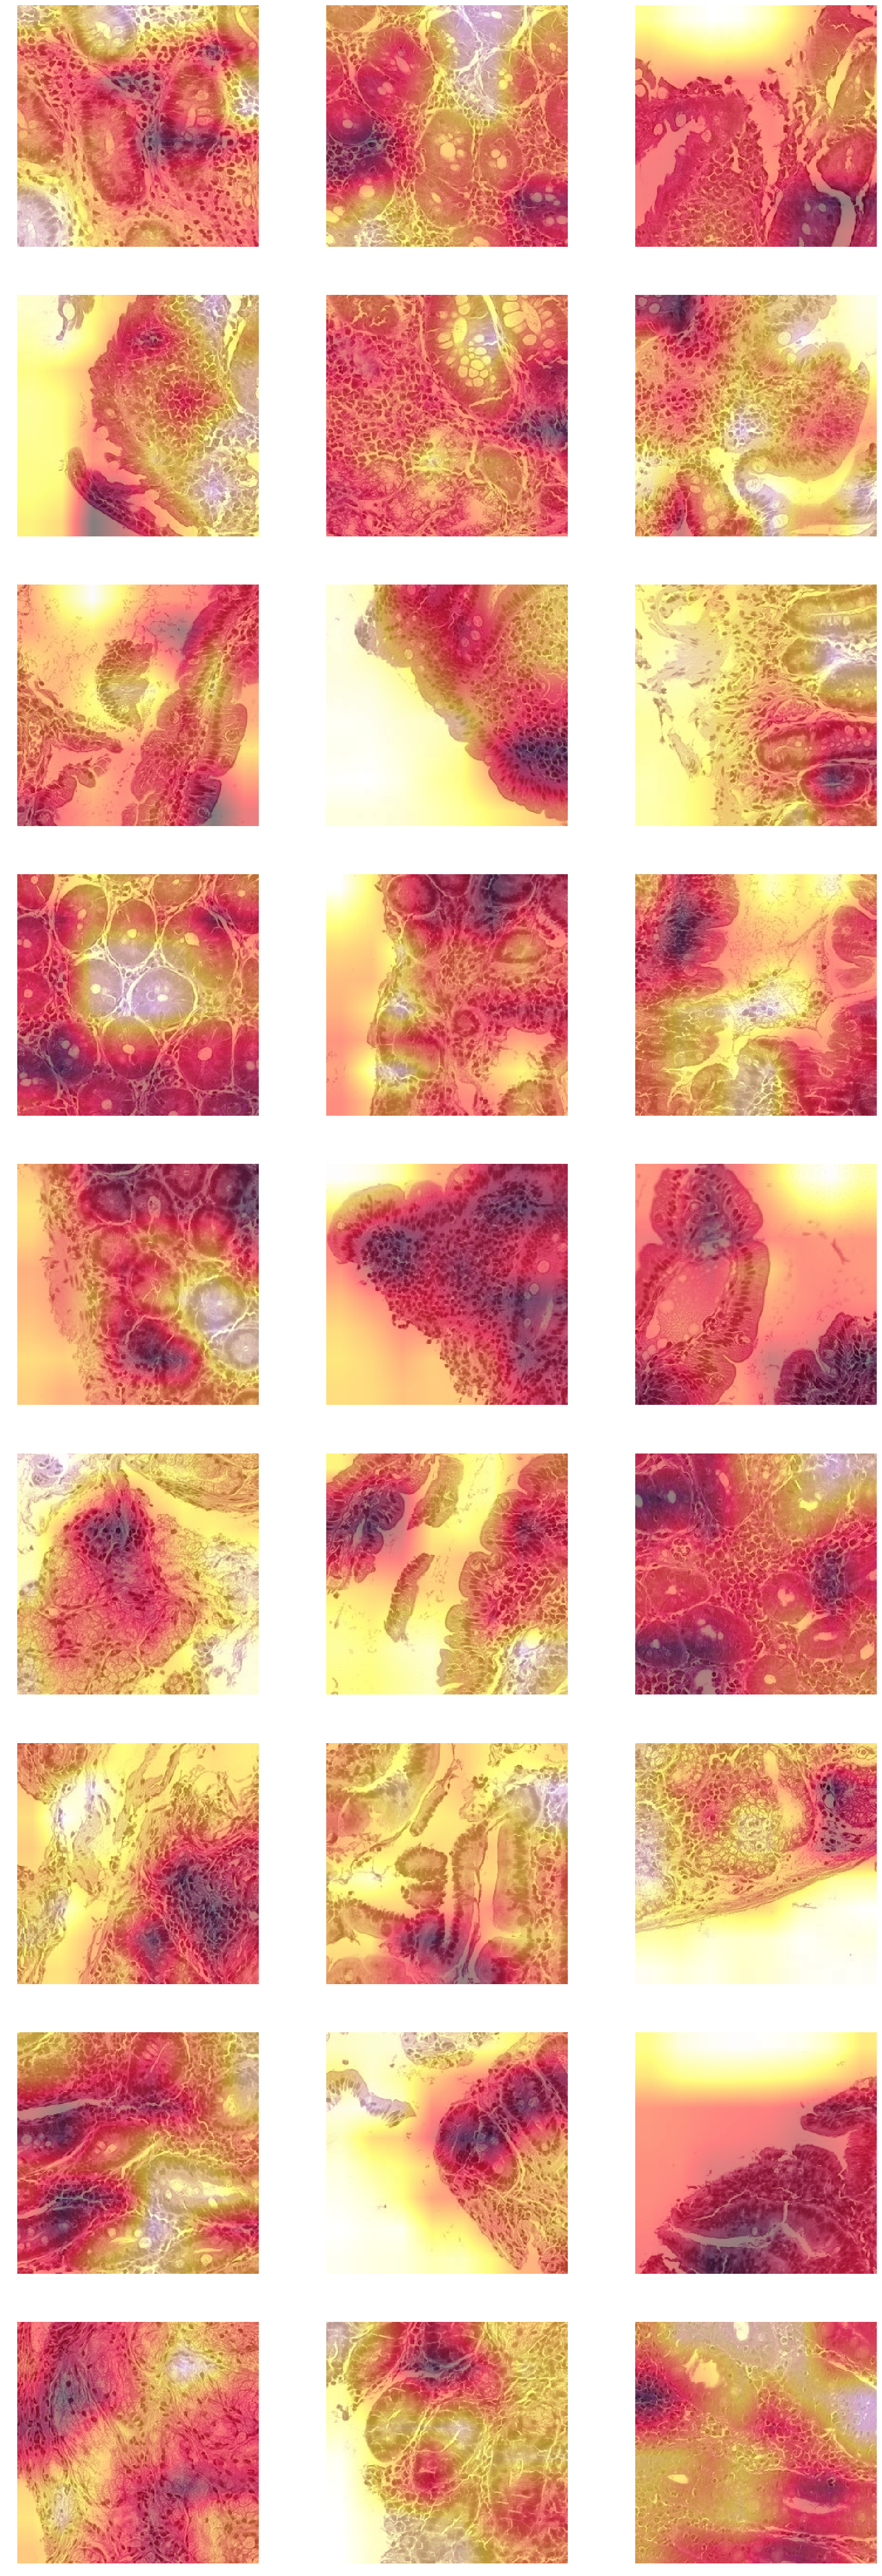

In [167]:
plt_heatmap()

In [124]:
x,y = next(iter(data.val_dl))

In [125]:
x,y = x[None,1], y[None,1]
vx = Variable(x.cuda(), requires_grad=True)

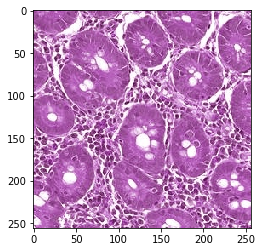

In [126]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [127]:
sfs = [SaveFeatures(o) for o in [m[-11][2]._modules['conv2']]]

In [128]:
%time py = m(Variable(x.cuda()))

CPU times: user 8.32 ms, sys: 1.82 ms, total: 10.1 ms
Wall time: 9.68 ms


In [129]:
for o in sfs: o.remove()

In [130]:
[o.features.size() for o in sfs]

[torch.Size([1, 512, 8, 8])]

In [131]:
py = np.exp(to_np(py)[0]); py

array([0.99999, 0.     , 0.00001], dtype=float32)

In [133]:
feat = np.maximum(0,to_np(sfs[0].features[0]))
feat.shape

(512, 8, 8)

In [ ]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

In [136]:
params = list(m.parameters())

In [138]:
params[-2]

Parameter containing:
tensor([[-0.0097, -0.0152,  0.0694,  ..., -0.1088,  0.0298,  0.0414],
        [-0.0357,  0.0006,  0.0231,  ...,  0.0900,  0.0527,  0.1012],
        [-0.0458, -0.0757, -0.0760,  ..., -0.0671,  0.1073, -0.0136]],
       device='cuda:0', requires_grad=True)

Text(0.5,1,'aman')

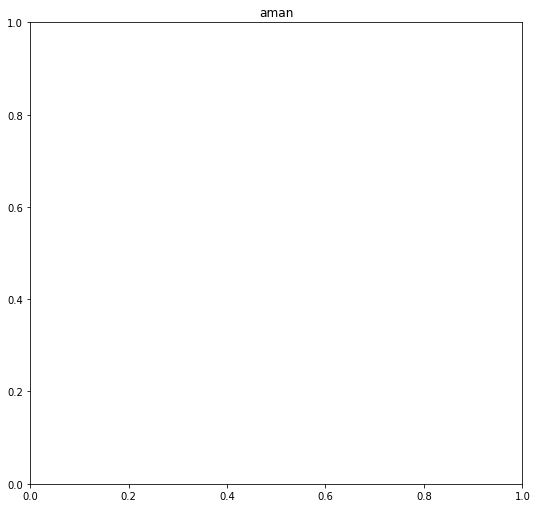

In [171]:
figure = plt.figure(figsize=(30, 90))
subplot = figure.add_subplot(9, 3, 1)
